<a href="https://colab.research.google.com/github/shohan007/ML-Engineered-Tissue-Evaluation/blob/main/DIS_GelMA_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#!pip install catboost

In [3]:
#sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.metrics import f1_score, make_scorer, accuracy_score, confusion_matrix, classification_report


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

In [37]:
#Reading the Dataset
df=pd.read_excel('/content/drive/MyDrive/DIS Data/DIS final datasheet for Gelma Paper.xlsx')
df.head()

,Events,174kHz,224kHz,287kHz,368kHz,473kHz,607kHz,779kHz,1000kHz,1284kHz,1648kHz,2115kHz,Cell Type,Time Period (in hour),Cell Quantity (in Million),Cell Type in Digit
0,Feed,1.331,1.207,0.562,0.745,0.594,0.360,0.247,0.279,0.045,0.148,0.058,MG63,24,1.0,1
1,0,1.387,1.270,0.969,0.789,0.569,0.320,0.264,0.244,0.095,0.174,0.047,MG63,24,1.0,1
2,0,1.344,1.297,0.736,0.825,0.592,0.307,0.249,0.167,0.024,0.149,-0.029,MG63,24,1.0,1
3,0,1.305,1.183,0.661,0.705,0.524,0.306,0.273,0.184,0.054,0.071,-0.011,MG63,24,1.0,1
4,0,1.345,1.052,0.692,0.787,0.577,0.359,0.263,0.265,0.031,0.102,-0.020,MG63,24,1.0,1


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


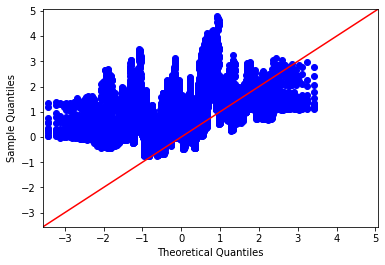

In [39]:
import statsmodels.api as sm
import pylab as py

outlier=df['2115kHz'].idxmax()
df.drop(index=outlier,inplace=True)
df.head()

sm.qqplot(df.iloc[:,1:12], line ='45')
py.show()

In [40]:
#Choosing Proper Cell Name
df['Cell Type'] = df['Cell Type'].str.replace('c2c12','C2C12')
df['Cell Type'] = df['Cell Type'].str.replace('3T3','NIH 3T3')
df['Cell Type'] = df['Cell Type'].str.replace('Chondro','Human Chondrocyte')
df['Cell Type'] = df['Cell Type'].str.replace('chondro','Human Chondrocyte')

In [41]:
df.columns

Index(['Events', '174kHz', '224kHz', '287kHz', '368kHz', '473kHz', '607kHz',
       '779kHz', '1000kHz', '1284kHz', '1648kHz', '2115kHz', 'Cell Type',
       'Time Period (in hour)', 'Cell Quantity (in Million)',
       'Cell Type in Digit'],
      dtype='object')

In [42]:
df[['Cell Type']].value_counts()

Cell Type        
C2C12                1078
NIH 3T3               720
MG63                  720
Human Chondrocyte     720
dtype: int64

In [43]:
X=df[['174kHz', '224kHz', '287kHz', '368kHz', '473kHz', '607kHz', '779kHz', '1000kHz', '1284kHz', '1648kHz', '2115kHz']]
Y=df[['Cell Type','Time Period (in hour)','Cell Quantity (in Million)']]

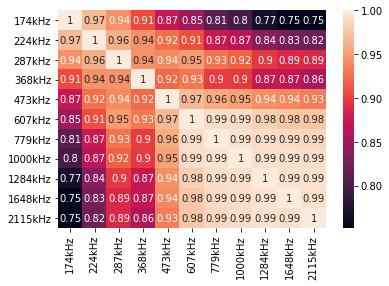

In [44]:
#Heatmap
sns.heatmap(X.corr(), annot=True);

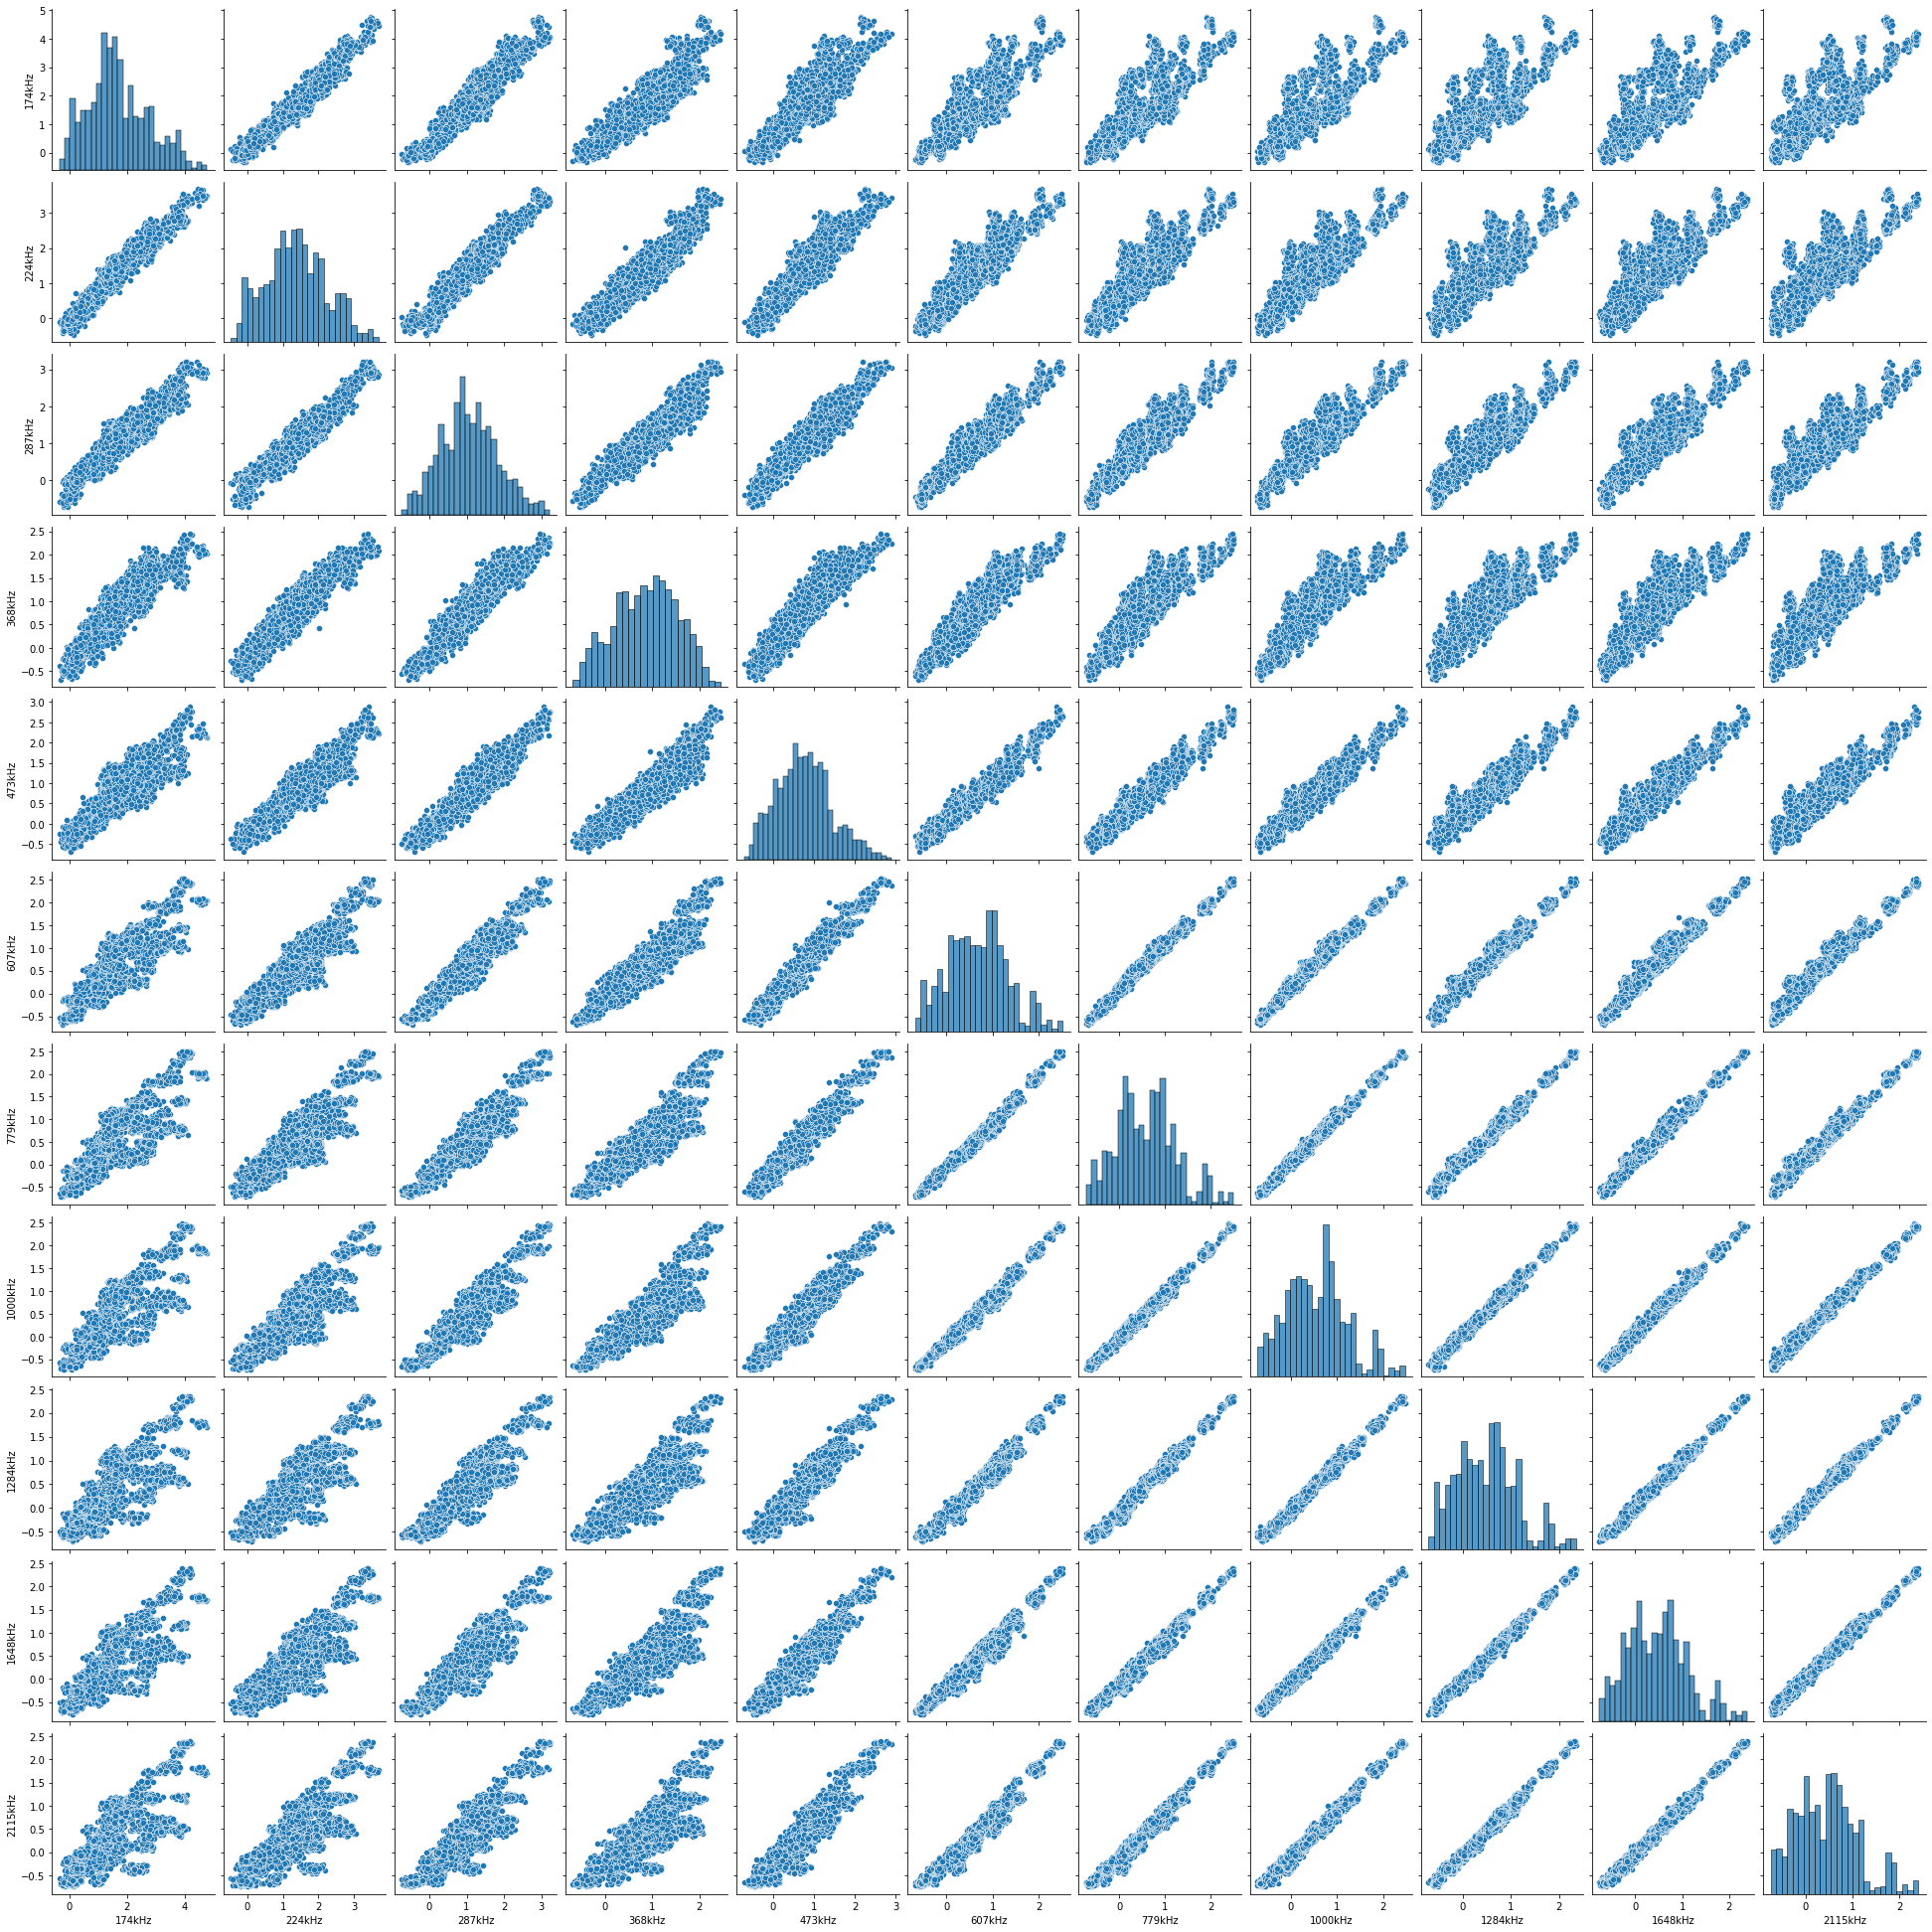

In [45]:
sns.pairplot(X)

Data Preprocessing

In [46]:
#Encoding the categorical Y
le1=LabelEncoder()
le2=LabelEncoder()
le3=LabelEncoder()
scaler=StandardScaler()

X_transformed=scaler.fit_transform(X)
Y_transformed_cell_type=le1.fit_transform(Y['Cell Type'])
Y_transformed_time=le2.fit_transform(Y['Time Period (in hour)'])
Y_transformed_quantity=le3.fit_transform(Y['Cell Quantity (in Million)'])

Utility Functions

In [47]:
# confusion matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
#Grid search

def grid_search(clf, parameters, scorer, train_data, test_data, cv=5):

    #Perform grid search on the classifier using 'scorer' as the scoring method.
    grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

    # Fit the grid search object to the training data and find the optimal parameters.
    grid_fit = grid_obj.fit(train_data[0], train_data[1])

    # Get the estimator.
    best_clf = grid_fit.best_estimator_

    # Fit the new model.
    best_clf.fit(train_data[0], train_data[1])

    # Make predictions using the new model.
    best_train_predictions = best_clf.predict(train_data[0])
    best_test_predictions = best_clf.predict(test_data[0])

    # Calculate the acc score of the new model.
    print('The training acc Score is', accuracy_score(best_train_predictions, train_data[1]))
    print('The testing acc Score is', accuracy_score(best_test_predictions, test_data[1]))
    print('The testing acc Score STD', np.mean(grid_obj.cv_results_['std_test_score']))


    # Let's also explore what parameters ended up being used in the new model.
    return grid_obj, best_clf

Function of SML models

In [49]:
# Logistics Regression with cross validation
def logistic_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    parameters = {'C':[.5, 1.0, 5, 10, 100, 1000]}
    scorer = make_scorer(accuracy_score)
    logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10_000) 
    
    # grid search
    grid_obj, best_clf = grid_search(logreg, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [50]:
# Decision Tree Classification with cross validation
def dtree_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    dtree = DecisionTreeClassifier()
    parameters = {'max_depth':[2,4,6,8,10],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}
    scorer = make_scorer(accuracy_score)


    # grid search
    grid_obj, best_clf = grid_search(dtree, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [51]:
# Support vector machine with cross validation
def svc_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    svc = SVC() 
    parameters = {'kernel':['poly', 'rbf','linear'],'C':[0.1, 1, 10], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
    scorer = make_scorer(accuracy_score)
   

    # grisearch
    grid_obj, best_clf = grid_search(svc, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [52]:
# K Nearest Neighbours with cross validation
def knn_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    knn = KNeighborsClassifier()
    neighbors = list(range(1, 30))  
    parameters = {'n_neighbors': neighbors}
    scorer = make_scorer(accuracy_score)
 
    # grisearch
    grid_obj, best_clf = grid_search(knn, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [53]:
# Random Forest with cross validation
def rf_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    rf= RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
    parameters = {}
    scorer = make_scorer(accuracy_score)

    # grisearch
    grid_obj, best_clf = grid_search(rf, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [54]:
# Naive Bayes with cross validation
def nb_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    nb= GaussianNB()
    parameters = {}
    scorer = make_scorer(accuracy_score)

    # grisearch
    grid_obj, best_clf = grid_search(nb, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [55]:
# XG Boosting Classifier with cross validation
def xgb_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    xgb= XGBClassifier()
    parameters = {}
    scorer = make_scorer(accuracy_score)

    # grisearch
    grid_obj, best_clf = grid_search(xgb, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [56]:
# CAT Boosting Classifier with cross validation
def catb_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    catb= CatBoostClassifier()
    scorer = make_scorer(accuracy_score)
    parameter={}

    # grisearch
    grid_obj, best_clf = grid_search(catb,parameter, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

#Cell Type Classification

In [57]:
# Train Test Dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_cell_type,
                                                test_size=0.3,
                                                random_state=42,
                                                stratify=Y_transformed_cell_type)


# create class names
class_names = np.unique(Y['Cell Type'])
class_names = [c for c in class_names]

In [58]:
class_names

['C2C12', 'Human Chondrocyte', 'MG63', 'NIH 3T3']

The training acc Score is 0.7409532215357458
The testing acc Score is 0.7325102880658436
The testing acc Score STD 0.009289400046219278
                   precision    recall  f1-score   support

            C2C12       0.90      0.90      0.90       324
Human Chondrocyte       0.68      0.80      0.74       216
             MG63       0.65      0.67      0.66       216
          NIH 3T3       0.59      0.47      0.53       216

         accuracy                           0.73       972
        macro avg       0.71      0.71      0.71       972
     weighted avg       0.73      0.73      0.73       972



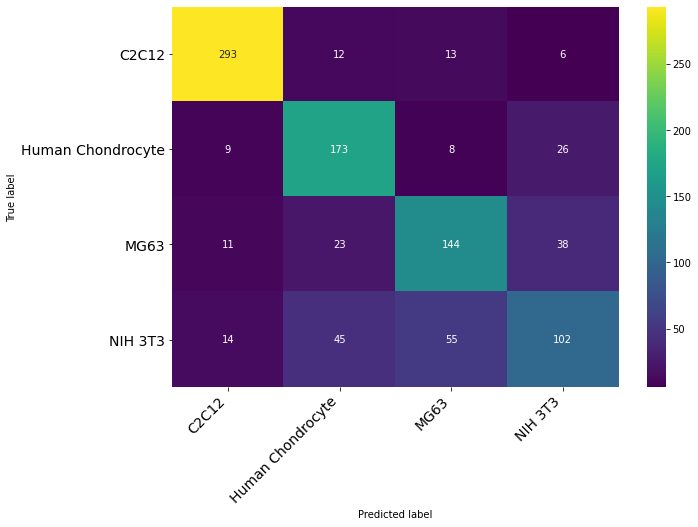

In [59]:
# logreg
logistic_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.9293909973521624
The testing acc Score is 0.7942386831275721
The testing acc Score STD 0.022530412847483958
                   precision    recall  f1-score   support

            C2C12       0.91      0.90      0.91       324
Human Chondrocyte       0.78      0.86      0.82       216
             MG63       0.71      0.78      0.74       216
          NIH 3T3       0.72      0.58      0.64       216

         accuracy                           0.79       972
        macro avg       0.78      0.78      0.78       972
     weighted avg       0.79      0.79      0.79       972



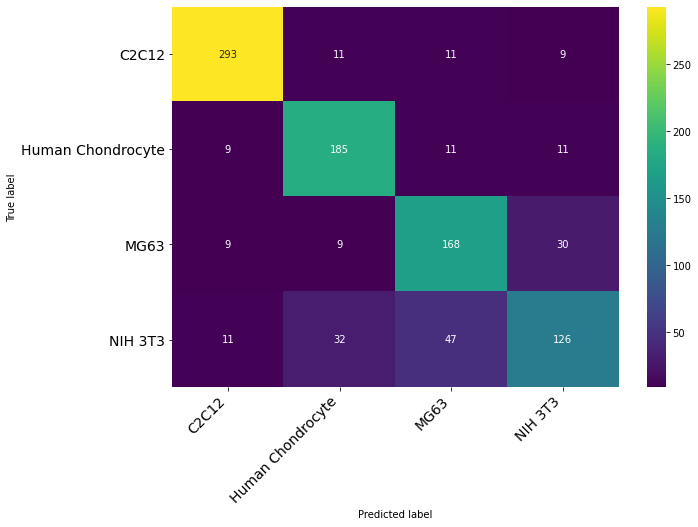

In [60]:
# dtree
dtree_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.9713150926743159
The testing acc Score is 0.9403292181069959
The testing acc Score STD 0.014804099613601369
                   precision    recall  f1-score   support

            C2C12       0.98      0.98      0.98       324
Human Chondrocyte       0.94      0.95      0.95       216
             MG63       0.94      0.90      0.92       216
          NIH 3T3       0.88      0.91      0.89       216

         accuracy                           0.94       972
        macro avg       0.94      0.94      0.94       972
     weighted avg       0.94      0.94      0.94       972



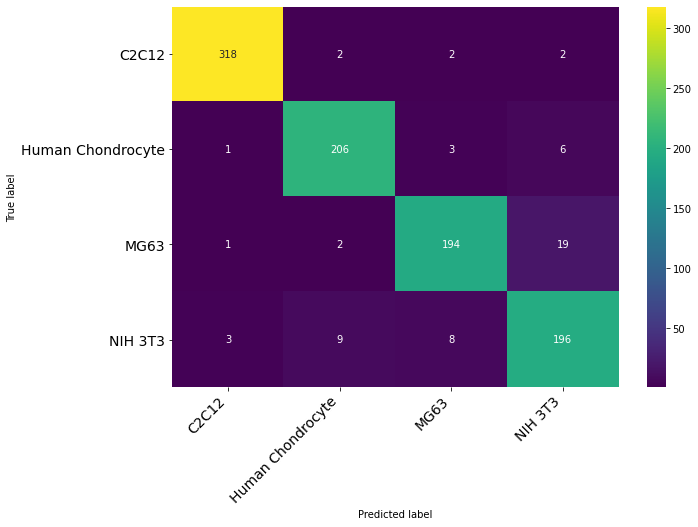

In [61]:
# svc
svc_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.9739629302736099
The testing acc Score is 0.9382716049382716
The testing acc Score STD 0.01237375285120208
                   precision    recall  f1-score   support

            C2C12       0.98      0.98      0.98       324
Human Chondrocyte       0.92      0.95      0.94       216
             MG63       0.92      0.91      0.92       216
          NIH 3T3       0.91      0.89      0.90       216

         accuracy                           0.94       972
        macro avg       0.93      0.93      0.93       972
     weighted avg       0.94      0.94      0.94       972



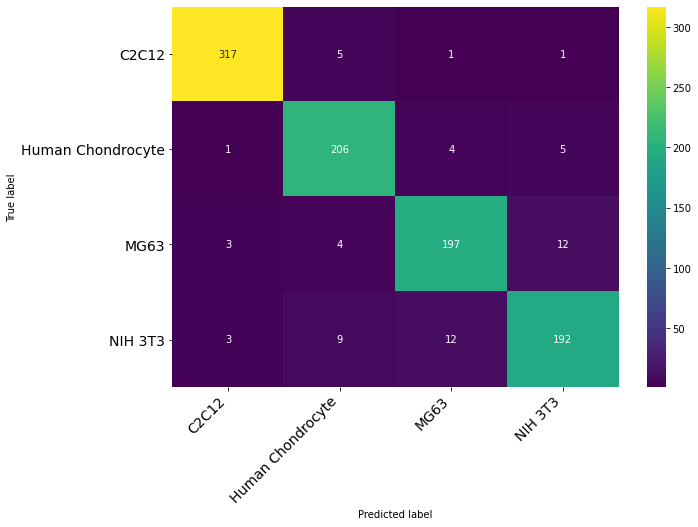

In [62]:
# knn
knn_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.9955869373345102
The testing acc Score is 0.8930041152263375
The testing acc Score STD 0.007173832285966159
                   precision    recall  f1-score   support

            C2C12       0.94      0.96      0.95       324
Human Chondrocyte       0.90      0.93      0.92       216
             MG63       0.85      0.86      0.85       216
          NIH 3T3       0.86      0.78      0.82       216

         accuracy                           0.89       972
        macro avg       0.89      0.88      0.88       972
     weighted avg       0.89      0.89      0.89       972



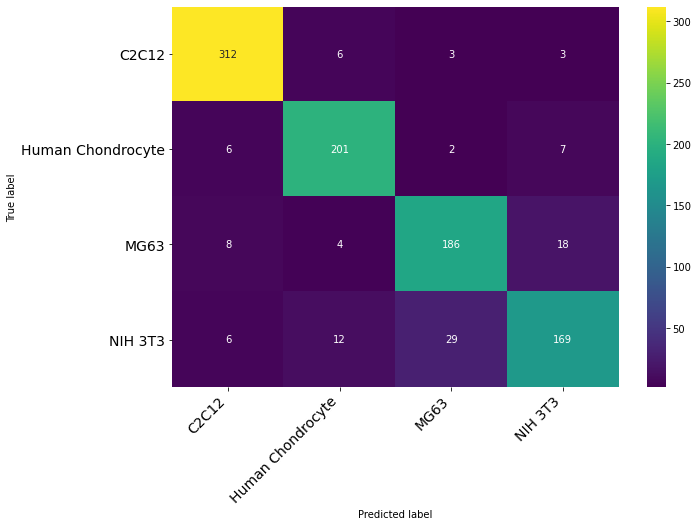

In [63]:
# rf
rf_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.5238305383936452
The testing acc Score is 0.5164609053497943
The testing acc Score STD 0.024426247297237576
                   precision    recall  f1-score   support

            C2C12       0.72      0.77      0.74       324
Human Chondrocyte       0.39      0.50      0.44       216
             MG63       0.50      0.14      0.22       216
          NIH 3T3       0.39      0.54      0.45       216

         accuracy                           0.52       972
        macro avg       0.50      0.49      0.46       972
     weighted avg       0.53      0.52      0.49       972



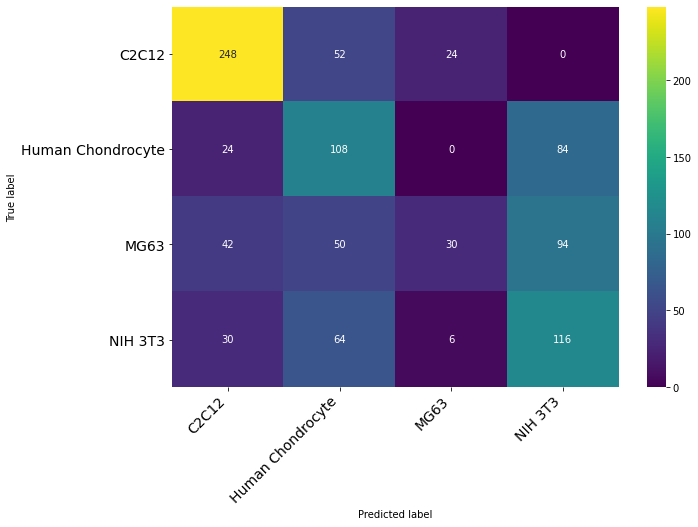

In [64]:
# nb
nb_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.9355692850838482
The testing acc Score is 0.8518518518518519
The testing acc Score STD 0.016988033258355732
                   precision    recall  f1-score   support

            C2C12       0.92      0.97      0.94       324
Human Chondrocyte       0.85      0.88      0.87       216
             MG63       0.82      0.81      0.81       216
          NIH 3T3       0.77      0.69      0.73       216

         accuracy                           0.85       972
        macro avg       0.84      0.84      0.84       972
     weighted avg       0.85      0.85      0.85       972



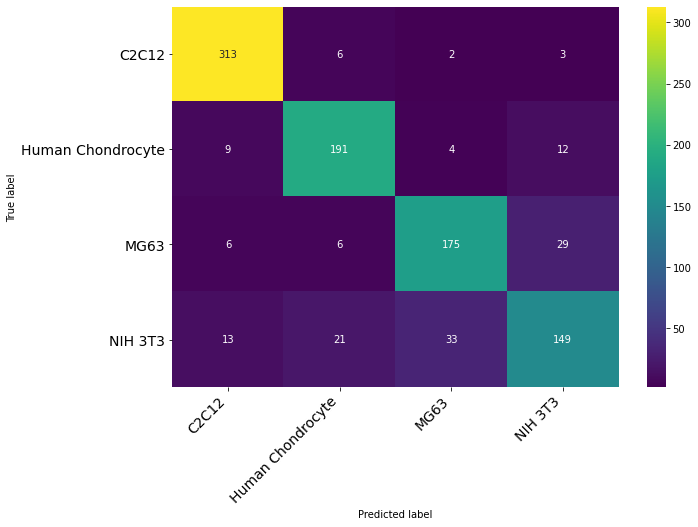

In [65]:
# xgb
xgb_cv((trainx, trainy), (testx, testy), class_names, 5)

In [66]:
# catb
#catb_cv((trainx, trainy), (testx, testy), class_names, 5)

#Time Duration Analysis

In [67]:

# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_time,
                                                test_size=0.3,
                                                random_state=42,
                                                stratify=Y_transformed_cell_type)


# create class names
class_names = np.unique(Y['Time Period (in hour)'])
class_names = [str(c)+'h' for c in class_names]

The training acc Score is 0.675639894086496
The testing acc Score is 0.6584362139917695
The testing acc Score STD 0.021676231807699103
              precision    recall  f1-score   support

         24h       0.70      0.69      0.70       225
         48h       0.64      0.57      0.60       228
         72h       0.70      0.69      0.69       277
         96h       0.60      0.68      0.64       242

    accuracy                           0.66       972
   macro avg       0.66      0.66      0.66       972
weighted avg       0.66      0.66      0.66       972



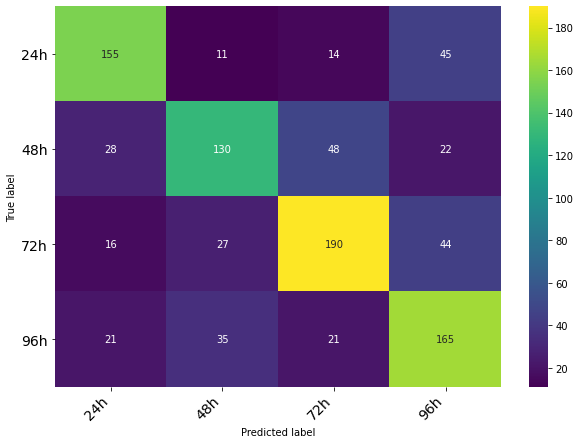

In [68]:
# logreg
logistic_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.8923212709620476
The testing acc Score is 0.7674897119341564
The testing acc Score STD 0.023248416175959376
              precision    recall  f1-score   support

         24h       0.82      0.83      0.83       225
         48h       0.71      0.74      0.72       228
         72h       0.80      0.75      0.78       277
         96h       0.74      0.75      0.74       242

    accuracy                           0.77       972
   macro avg       0.77      0.77      0.77       972
weighted avg       0.77      0.77      0.77       972



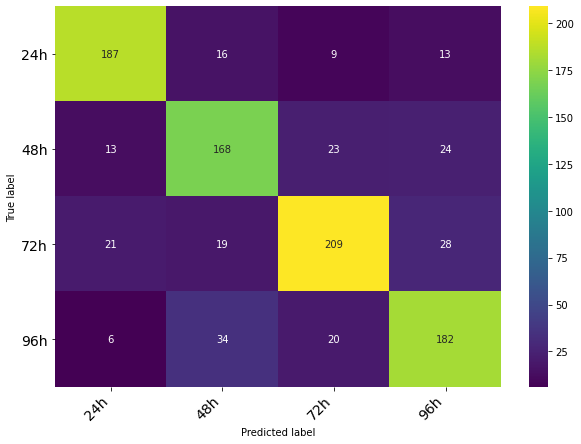

In [69]:
# dtree
dtree_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.9766107678729038
The testing acc Score is 0.9495884773662552
The testing acc Score STD 0.018214722353624525
              precision    recall  f1-score   support

         24h       0.93      0.97      0.95       225
         48h       0.97      0.92      0.95       228
         72h       0.95      0.96      0.95       277
         96h       0.95      0.95      0.95       242

    accuracy                           0.95       972
   macro avg       0.95      0.95      0.95       972
weighted avg       0.95      0.95      0.95       972



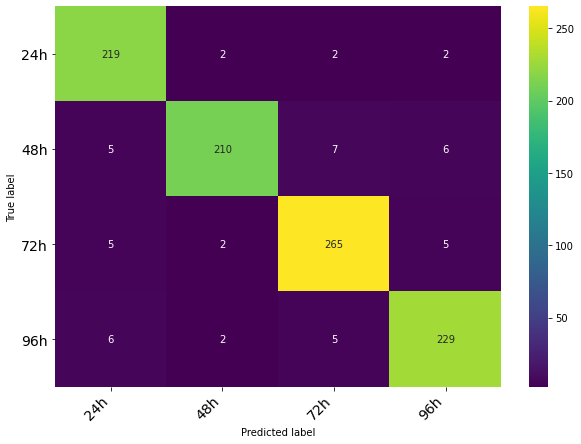

In [70]:
# svc
svc_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.9744042365401588
The testing acc Score is 0.9310699588477366
The testing acc Score STD 0.013333538795556992
              precision    recall  f1-score   support

         24h       0.93      0.93      0.93       225
         48h       0.94      0.93      0.93       228
         72h       0.94      0.91      0.93       277
         96h       0.91      0.95      0.93       242

    accuracy                           0.93       972
   macro avg       0.93      0.93      0.93       972
weighted avg       0.93      0.93      0.93       972



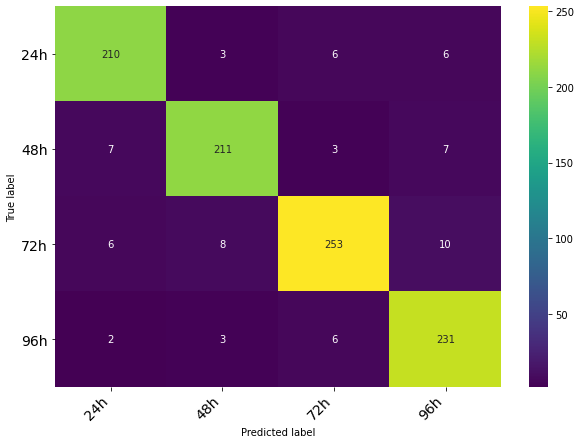

In [71]:
# knn
knn_cv((trainx, trainy), (testx, testy),class_names, 5)

The training acc Score is 0.9982347749338041
The testing acc Score is 0.8899176954732511
The testing acc Score STD 0.012750854011291975
              precision    recall  f1-score   support

         24h       0.87      0.92      0.90       225
         48h       0.90      0.85      0.87       228
         72h       0.92      0.87      0.90       277
         96h       0.87      0.92      0.89       242

    accuracy                           0.89       972
   macro avg       0.89      0.89      0.89       972
weighted avg       0.89      0.89      0.89       972



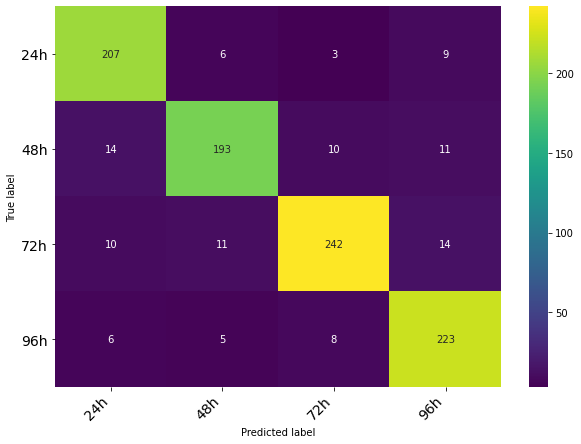

In [72]:
# rf
rf_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.4730803177405119
The testing acc Score is 0.43209876543209874
The testing acc Score STD 0.020957331892320914
              precision    recall  f1-score   support

         24h       0.36      0.49      0.42       225
         48h       0.54      0.29      0.38       228
         72h       0.50      0.34      0.41       277
         96h       0.42      0.61      0.50       242

    accuracy                           0.43       972
   macro avg       0.46      0.43      0.42       972
weighted avg       0.46      0.43      0.42       972



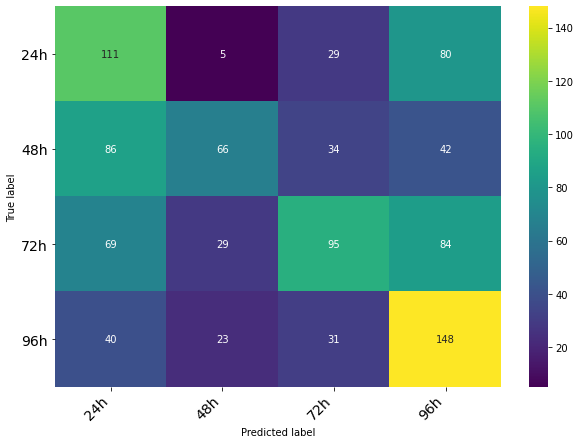

In [73]:
# nb
nb_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.9311562224183584
The testing acc Score is 0.8662551440329218
The testing acc Score STD 0.017411650342953597
              precision    recall  f1-score   support

         24h       0.86      0.86      0.86       225
         48h       0.88      0.86      0.87       228
         72h       0.91      0.84      0.87       277
         96h       0.82      0.91      0.87       242

    accuracy                           0.87       972
   macro avg       0.87      0.87      0.87       972
weighted avg       0.87      0.87      0.87       972



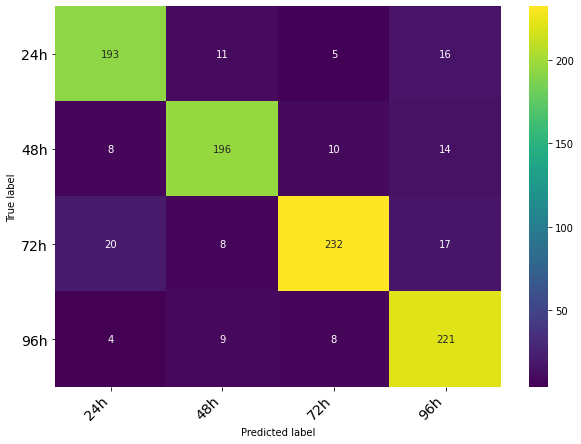

In [74]:
# xgb
xgb_cv((trainx, trainy), (testx, testy), class_names, 5)

In [75]:
# catb
#catb_cv((trainx, trainy), (testx, testy), class_names, 5)

#Cell Quantity Analysis

In [76]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_quantity,
                                                test_size=0.3,
                                                random_state=42,
                                                stratify=Y_transformed_cell_type)


# create class names
class_names = np.unique(Y['Cell Quantity (in Million)'])
class_names = [str(c)+'h' for c in class_names]

The training acc Score is 0.6372462488967343
The testing acc Score is 0.6378600823045267
The testing acc Score STD 0.024109373861317295
              precision    recall  f1-score   support

        0.5h       0.69      0.68      0.69       340
        1.0h       0.54      0.53      0.53       312
        2.0h       0.68      0.70      0.69       320

    accuracy                           0.64       972
   macro avg       0.63      0.64      0.64       972
weighted avg       0.64      0.64      0.64       972



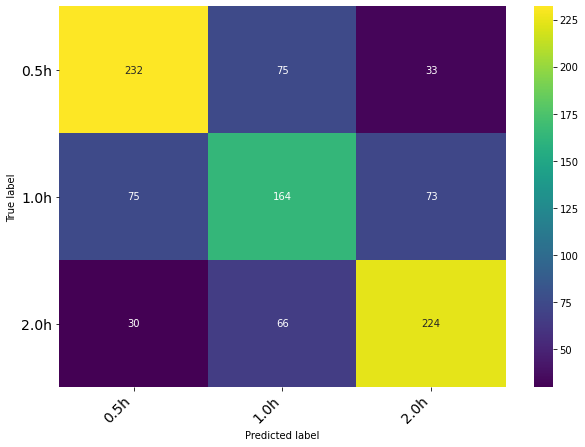

In [77]:
# logreg
logistic_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.9527802294792586
The testing acc Score is 0.8508230452674898
The testing acc Score STD 0.023033915436794655
              precision    recall  f1-score   support

        0.5h       0.87      0.87      0.87       340
        1.0h       0.84      0.84      0.84       312
        2.0h       0.84      0.84      0.84       320

    accuracy                           0.85       972
   macro avg       0.85      0.85      0.85       972
weighted avg       0.85      0.85      0.85       972



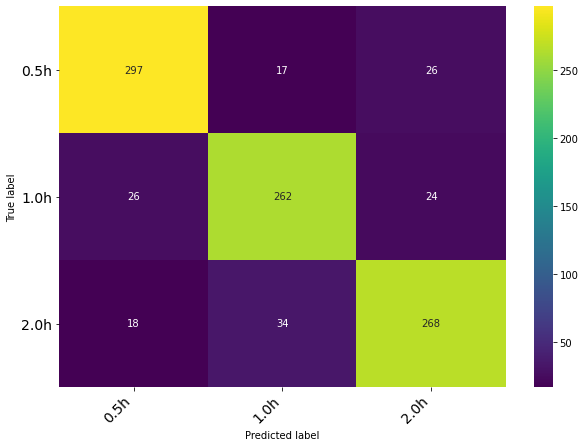

In [78]:
# dtree
dtree_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.9691085613415711
The testing acc Score is 0.9300411522633745
The testing acc Score STD 0.014852804932347086
              precision    recall  f1-score   support

        0.5h       0.94      0.95      0.94       340
        1.0h       0.92      0.92      0.92       312
        2.0h       0.93      0.92      0.93       320

    accuracy                           0.93       972
   macro avg       0.93      0.93      0.93       972
weighted avg       0.93      0.93      0.93       972



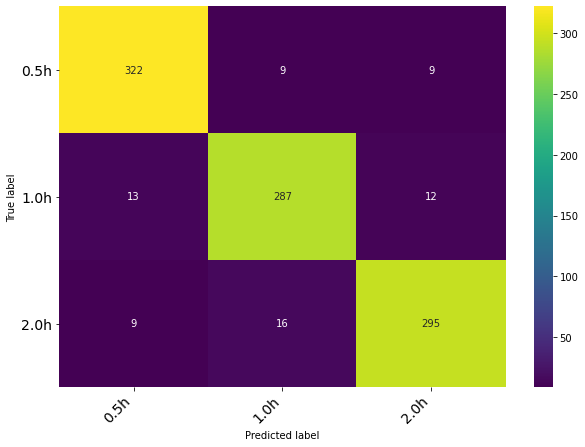

In [79]:
# svc
svc_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.970432480141218
The testing acc Score is 0.9495884773662552
The testing acc Score STD 0.012406638713276186
              precision    recall  f1-score   support

        0.5h       0.94      0.97      0.95       340
        1.0h       0.94      0.94      0.94       312
        2.0h       0.97      0.94      0.95       320

    accuracy                           0.95       972
   macro avg       0.95      0.95      0.95       972
weighted avg       0.95      0.95      0.95       972



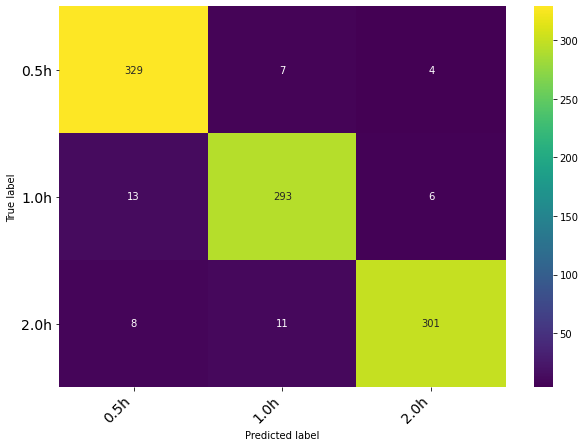

In [80]:
# knn
knn_cv((trainx, trainy), (testx, testy),class_names, 5)

The training acc Score is 0.9969108561341571
The testing acc Score is 0.9146090534979424
The testing acc Score STD 0.013547603549857989
              precision    recall  f1-score   support

        0.5h       0.91      0.95      0.93       340
        1.0h       0.89      0.93      0.91       312
        2.0h       0.95      0.87      0.91       320

    accuracy                           0.91       972
   macro avg       0.92      0.91      0.91       972
weighted avg       0.92      0.91      0.91       972



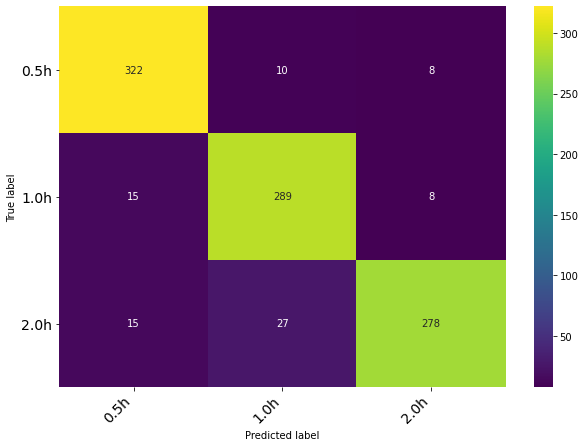

In [81]:
# rf
rf_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.4646954986760812
The testing acc Score is 0.4845679012345679
The testing acc Score STD 0.015392004437349857
              precision    recall  f1-score   support

        0.5h       0.48      0.59      0.53       340
        1.0h       0.40      0.28      0.33       312
        2.0h       0.54      0.57      0.55       320

    accuracy                           0.48       972
   macro avg       0.47      0.48      0.47       972
weighted avg       0.48      0.48      0.47       972



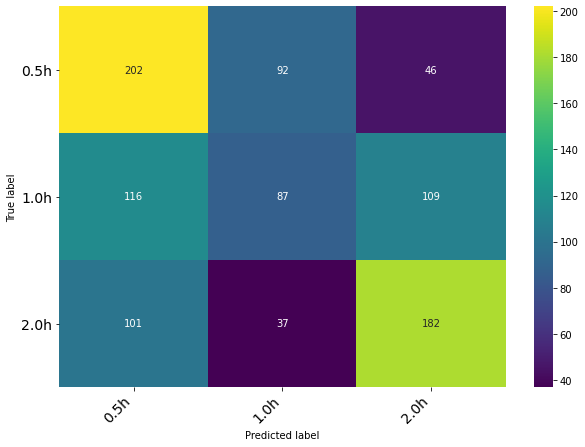

In [82]:
# nb
nb_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.9148278905560459
The testing acc Score is 0.8292181069958847
The testing acc Score STD 0.01581540877037959
              precision    recall  f1-score   support

        0.5h       0.87      0.83      0.85       340
        1.0h       0.79      0.83      0.81       312
        2.0h       0.84      0.83      0.83       320

    accuracy                           0.83       972
   macro avg       0.83      0.83      0.83       972
weighted avg       0.83      0.83      0.83       972



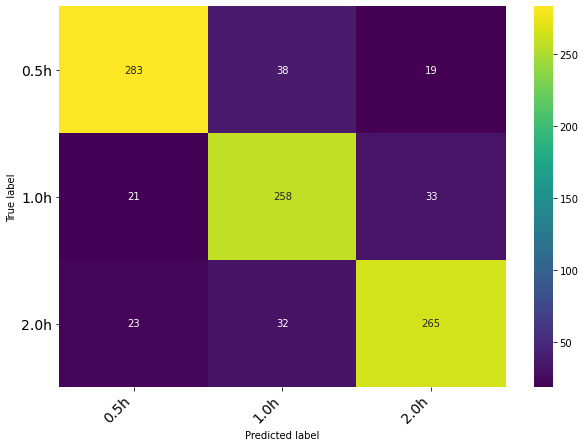

In [83]:
# xgb
xgb_cv((trainx, trainy), (testx, testy), class_names, 5)

In [84]:
#catb
#catb_cv((trainx, trainy), (testx, testy), class_names, 5)

#PCA Analysis

In [85]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed_x = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.91393481, 0.06758103])

In [86]:
Y['Cell Quantity (in Million)']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
3234    2.0
3235    2.0
3236    2.0
3237    2.0
3238    2.0
Name: Cell Quantity (in Million), Length: 3238, dtype: float64

In [87]:
pca_df = pd.DataFrame(data=np.c_[pca_transformed_x, Y['Cell Type']],
                       columns=['x1','x2', 'cell_type'])
pca_df.head()

,x1,x2,cell_type
0,-1.02602,0.215545,MG63
1,-0.841729,0.32564,MG63
2,-0.983856,0.359199,MG63
3,-1.11438,0.278174,MG63
4,-1.06255,0.241744,MG63


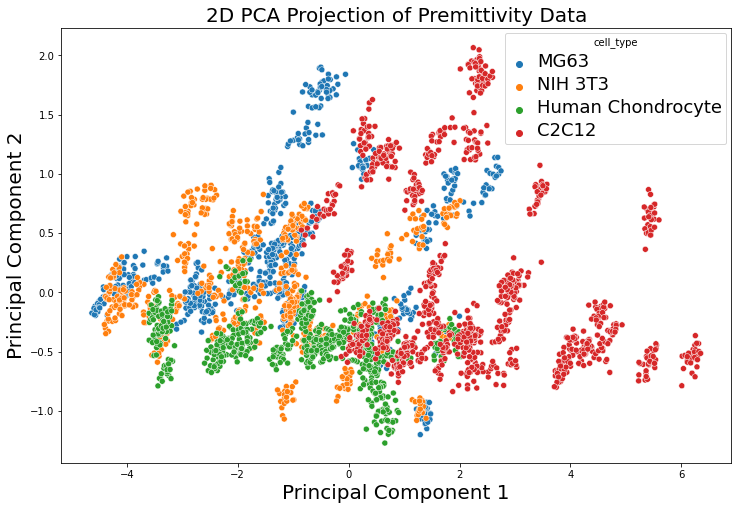

In [88]:

f, ax = plt.subplots(1,1, figsize=(12,8))
sns.scatterplot(data=pca_df, x='x1', y='x2', hue='cell_type', ax=ax)
ax.set_xlabel("Principal Component 1", fontsize=20)
ax.set_ylabel("Principal Component 2", fontsize=20)
ax.set_title("2D PCA Projection of Premittivity Data", fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [89]:
from sklearn import manifold
####### TSNE
tsne = manifold.TSNE(n_components=2, random_state=42)
tnse_transformed_x = tsne.fit_transform(X)
tsne_df = pd.DataFrame(data=np.c_[tnse_transformed_x, Y['Cell Type']],
                       columns=['x1', 'x2', 'cell_type'])

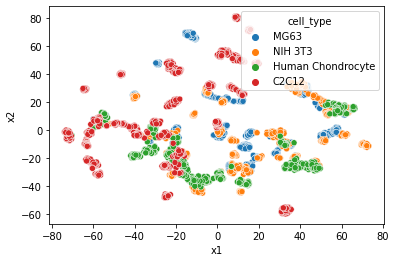

In [90]:
sns.scatterplot(data=tsne_df, x='x1', y='x2', hue='cell_type')